### train results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load the log file
file_path = 'log_train1000video.txt'

# Extract epoch and loss values
data = []
test_ = []
with open(file_path, 'r') as file:
    for line in file:
        entry = json.loads(line)
        if 'train_loss' in entry:
            data.append((entry['epoch'], entry['train_loss']))
        elif 'test_loss' in entry:
            test_.append((entry['epoch'], entry['test_loss']))

# Create a DataFrame for plotting
df_train = pd.DataFrame(data, columns=['Epoch', 'Train Loss'])
df_test =  pd.DataFrame(test_, columns=['Epoch', 'Test Loss']) #['Test Loss'] 

In [2]:
df = pd.merge(df_train, df_test, on="Epoch", how="left")
# Riempire i valori mancanti nel test con forward fill
df["Test Loss"] = df["Test Loss"].fillna(method="ffill")

/tmp/ipykernel_68218/2361901999.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Test Loss"] = df["Test Loss"].fillna(method="ffill")


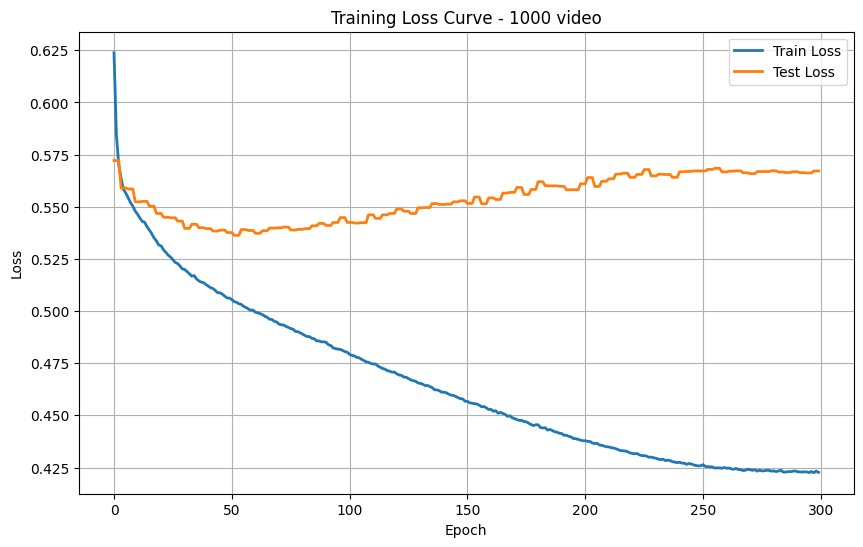

In [3]:
#df = df_tot.iloc[3:]
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss', linewidth=2)
plt.plot(df['Epoch'], df['Test Loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve - 1000 video')
plt.legend()
plt.grid(True)
plt.show()

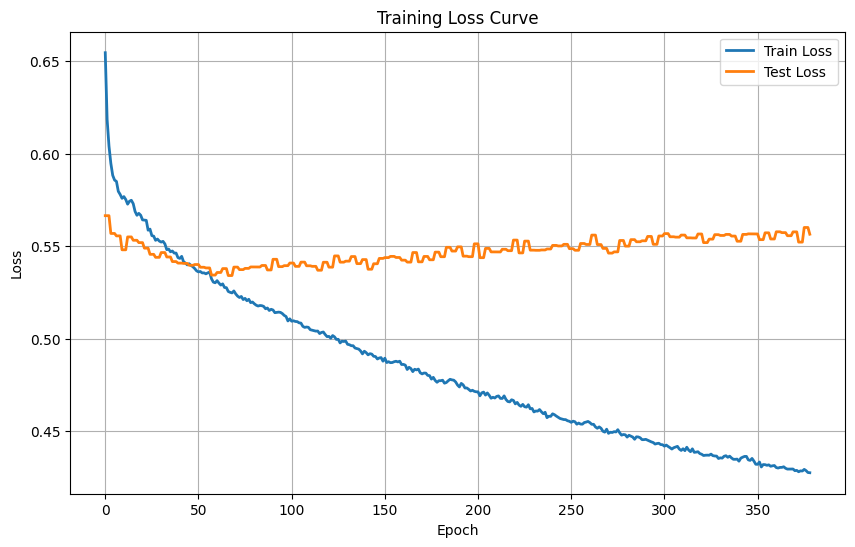

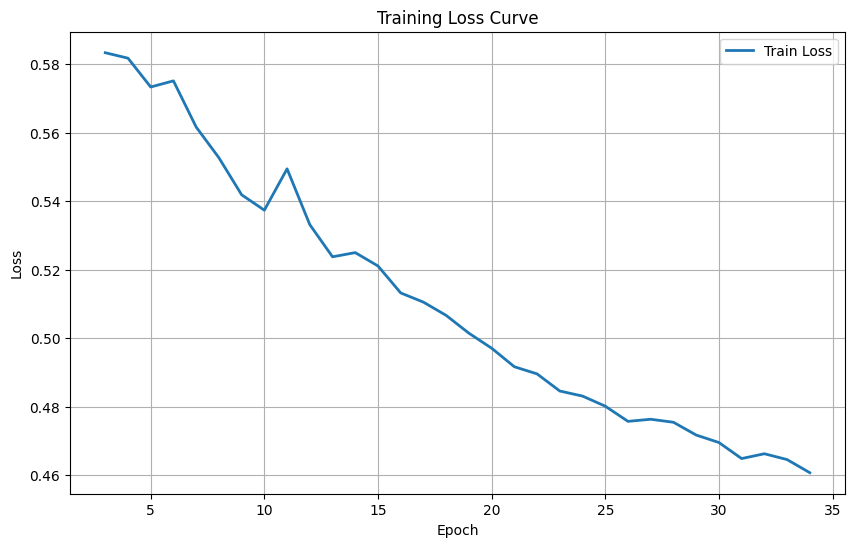

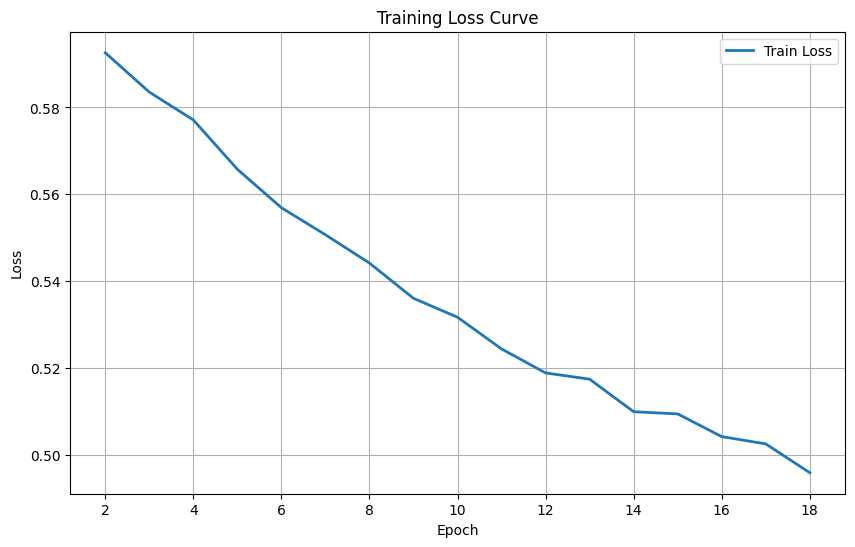

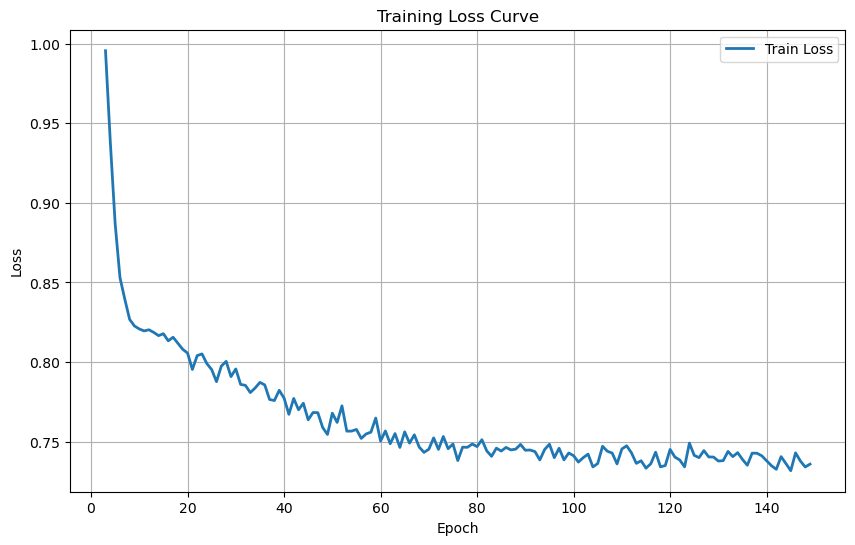

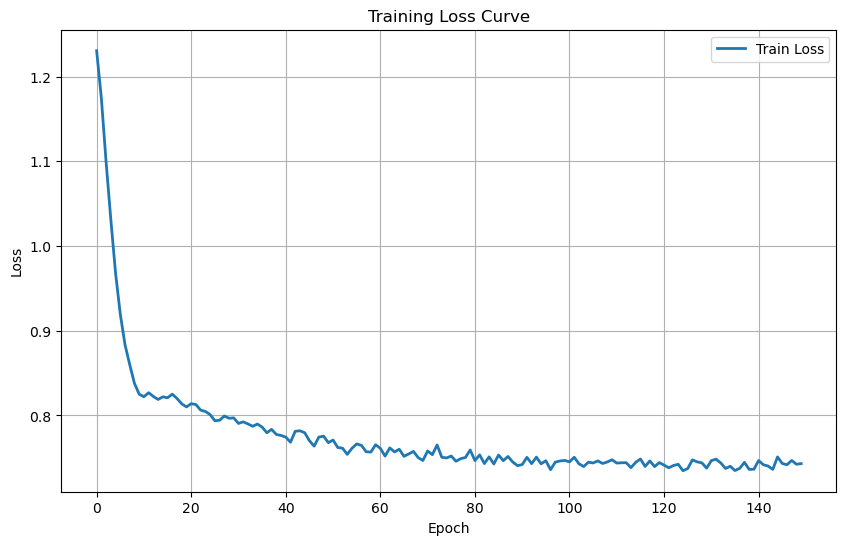

In [5]:
from PIL import Image
import glob

# Trova tutte le immagini PNG nella directory (es. "immagini/*.png")
image_files = sorted(glob.glob("/home/daniele/Documenti/Progetti/VideoMAEv2/sequenced_imgs/freq-6.2_part45/*.png"))  # Ordina per nome
frames = [Image.open(img) for img in image_files]

# Salva la GIF
frames[0].save(
    "animazione.gif",
    save_all=True,
    append_images=frames[1:],  # Aggiungi le altre immagini
    duration=200,  # Durata di ogni frame in millisecondi
    loop=0  # Loop infinito (imposta a 1 per una sola ripetizione)
)
print("GIF salvata come animazione.gif")


GIF salvata come animazione.gif


# Verifica con step di inferenza su un video

In [1]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
#import torchvision.transforms as transforms
#import torchvision.transforms.functional as F
import torch.nn.functional as F

from utils import multiple_pretrain_samples_collate
from functools import partial

from dataset import build_pretraining_dataset
from torch.utils.data import DataLoader
from utils import get_model
from arguments import prepare_args, Args  # NON TOGLIERE: serve a torch.load per caricare il mio modello addestrato

from einops import rearrange

from dataset.data_manager import DataManager

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD  = (0.229, 0.224, 0.225)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Impossibile caricare la libreria torch dynamo


In [2]:


def visualize_frame(image_tensor, i, t):
    """
    Visualizza un frame da un tensore (batch, canali, frames, H, W).
    """
    image_tensor = image_tensor[i, :, t]  # Prendi il primo batch, primi 3 canali, primo frame
    image_tensor = image_tensor.permute(1, 2, 0).cpu().numpy()  # Cambia dimensioni per Matplotlib

    plt.imshow(image_tensor)
    plt.axis("off")
    #plt.title("Frame Ricostruito")
    plt.show()

import imageio
def save_animation_gif(frames, filename="output.gif", fps=8):
    """
    Salva la prima clip di `recon` (B,3,T,H,W) come GIF.
    """
    #frames = recon[0]  # (3,T,H,W)
    frames_np = frames.permute(1,2,3,0).cpu().numpy()  # (T,H,W,3)

    # Se i valori sono in [0,1], scaliamo a [0,255]
    frames_uint8 = (frames_np * 255).clip(0,255).astype(np.uint8)

    imageio.mimsave(filename, frames_uint8, fps=fps, loop=100)

In [2]:
args = prepare_args()
args.test_path = 'test_dataset_2802.csv'
args.init_ckpt = './output/checkpoint_88k.pth'
args.load_for_test_mode= True
device = torch.device(args.device)

#patch_size = specialized_model.encoder.patch_embed.patch_size
patch_size = [14,14]
test_m = DataManager(is_train=False, args=args, type_t='unsupervised', patch_size=patch_size)
test_m.create_specialization_dataloader(args)

# Carica i modelli
specialized_model = get_model(args)
specialized_model.to(device)


Patch size = [14, 14]
Window size : (8, 16, 16)
Getting dataset...
File di dati: test_dataset_2802.csv


NameError: name 'get_video_loader' is not defined

## test input dataset

In [6]:
with torch.no_grad():
    images, bool_masked_pos, decode_masked_pos = next(iter(test_m.data_loader))
    images = images.to(args.device)
    bool_masked_pos = bool_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
    decode_masked_pos = decode_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
    output = specialized_model(images, bool_masked_pos, decode_masked_pos)

/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [7]:
images.shape, output.shape

(torch.Size([6, 3, 16, 224, 224]), torch.Size([6, 1024, 1176]))

In [8]:
len(test_m.data_loader)

4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


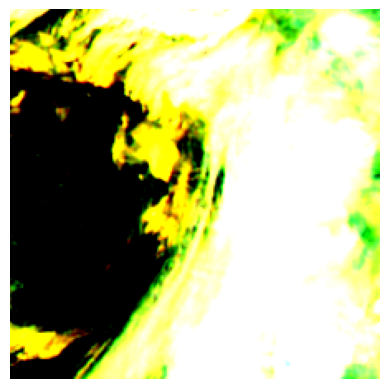

In [10]:
visualize_frame(images, 5, 7)

In [34]:
save_animation_gif(images[3], "my_original.gif", fps=10)

### Maschere

In [11]:
bool_masked_pos.shape, decode_masked_pos.shape, bool_masked_pos.sum(), bool_masked_pos.numel(), decode_masked_pos.sum()

(torch.Size([6, 2048]),
 torch.Size([6, 2048]),
 tensor(9216, device='cuda:0'),
 12288,
 tensor(6144, device='cuda:0'))

In [5]:
3136/1568, 2816/3136

(2.0, 0.8979591836734694)

In [12]:
print("bool_masked_pos =", bool_masked_pos.shape, bool_masked_pos.sum(dim=1))
print("decode_masked_pos =", decode_masked_pos.shape, decode_masked_pos.sum(dim=1))


bool_masked_pos = torch.Size([6, 2048]) tensor([1536, 1536, 1536, 1536, 1536, 1536], device='cuda:0')
decode_masked_pos = torch.Size([6, 2048]) tensor([1024, 1024, 1024, 1024, 1024, 1024], device='cuda:0')


### Input e output

In [13]:
print(f"input: {images.shape} - tot size {images.numel()}")
print(f"output: {output.shape} - tot size {output.numel()}")

B, C, T, H, W = images.shape
B, N_patch, patch_dim = output.shape

input: torch.Size([6, 3, 16, 224, 224]) - tot size 14450688
output: torch.Size([6, 1024, 1176]) - tot size 7225344


input: torch.Size([2, 3, 16, 224, 224]) - tot size 4816896
output: torch.Size([2, 784, 1536]) - tot size 2408448


[14, 14]

In [15]:
# PATCH DIMENSION

# Supponiamo patch_dim = C * tubelet_size * patch_H * patch_W
tubelet_size = 2
patch_H = patch_size[0]
patch_W = patch_size[1]

# verificato
print(patch_dim)
patch_W * patch_H * C * tubelet_size == patch_dim

1176


True

In [16]:
num_p = np.array((H,W)) / np.array((patch_H, patch_W))
print(f" Numero di patch per lato {num_p}")
print(f"Time frames / tubelet size = frame temporali = {T / tubelet_size}")

 Numero di patch per lato [16. 16.]
Time frames / tubelet size = frame temporali = 8.0


In [17]:
num_patches = num_p[0] * num_p[1] * ( T / tubelet_size)
num_patches

2048.0

In [18]:
print(f"abbiamo la metà di maschere nel decoder: {num_patches/2} ")

abbiamo la metà di maschere nel decoder: 1024.0 


## ricostruzione

In [22]:
def reconstruct_mae_batch(
    model,                 # il tuo modello pretrain_videomae (già su device)
    images,               # shape (B, 3, T, H, W) su device
    bool_masked_pos,      # shape (B, N), True dove mascherato per l'encoder
    decode_masked_pos,    # shape (B, N), True dove mascherato per il decoder
    patch_size,
    tubelet_size=2,
    normlize_target=True,
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
):
    """
    Ricostruisce le immagini/video mascherati da un MAE addestrato
    con local patch normalization, restituendo (B, 3, T, H, W) in [0,1].
    """

    device = images.device
    B, C, T, H, W = images.shape
    # Attenzione: T, H, W devono essere multipli di tubelet_size, patch_size

    # -------------------------------------------------
    # 1) Ricalcolo unnorm_images = ( x * std ) + mean
    #    (ovvero rimuovo la normalizzazione globale ImageNet)
    # -------------------------------------------------
    mean_5d = torch.as_tensor(mean, device=device)[None, :, None, None, None]
    std_5d  = torch.as_tensor(std,  device=device)[None, :, None, None, None]
    unnorm_images = images * std_5d + mean_5d  # [0..1] (circa)
    
    # -------------------------------------------------
    # 2) Patchify "alla maniera" del training 
    #    e calcolo mean/std localmente per ogni patch
    # -------------------------------------------------
    # Einops: raggruppiamo T su (t p0), H su (h p1), W su (w p2).
    # Nel tuo train_one_epoch vedo: p0=2, p1=16, p2=16 => tubelet_size=2, patch_size=16
    # -> shape: (B, (t h w), (p0*p1*p2), C)
    images_squeeze = rearrange(
        unnorm_images,
        'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2) c',
        p0=tubelet_size, p1=patch_size, p2=patch_size
    )
    # shape = (B, N, patch_vol, 3), con patch_vol = tubelet_size*patch_size*patch_size

    # Calcoliamo la mean e std locali (patch-wise)
    mu_p = images_squeeze.mean(dim=-2, keepdim=True)            # (B, N, 1, 3)
    sigma_p = (images_squeeze.var(dim=-2, unbiased=True, keepdim=True).sqrt() + 1e-6)

    # Normalizzo i patch localmente => "target style" 
    images_norm = (images_squeeze - mu_p) / sigma_p             # (B, N, patch_vol, 3)

    # Infine reshapo in (B, N, patch_vol*3)
    images_patch_norm = rearrange(images_norm, 'b n p c -> b n (p c)')

    # -------------------------------------------------
    # 3) Forward del modello: produce patch ricostruiti
    #    (solo per i patch mascherati dal decoder)
    # -------------------------------------------------
    # bool_masked_pos e decode_masked_pos => (B, N), boole
    outputs = model(images, bool_masked_pos, decode_masked_pos)
    # outputs.shape => (B, M, patch_vol*3) se M = # patch mascherati dal decoder

    # -------------------------------------------------
    # 4) Inseriamo i patch ricostruiti nelle posizioni mascherate
    #    (nel dominio "patch normalizzato"!)
    # -------------------------------------------------
    recon_patches = images_patch_norm.clone()  # (B, N, patch_vol*3)
    # Sostituisco i patch mascherati
    # "outputs.view(-1,  patch_vol*3)" => shape = (B*M, patch_vol*3) 
    recon_patches[decode_masked_pos] = outputs.view(-1, patch_size*patch_size*tubelet_size*3)

    # -------------------------------------------------
    # 5) Invertiamo la normalizzazione locale patch-wise
    # -------------------------------------------------
    #  Ritorno a shape (B, N, patch_vol, 3)
    recon_patches_4d = rearrange(recon_patches, 'b n (p c) -> b n p c', p=patch_size*patch_size*tubelet_size, c=3)
    #  Ora recon_patches_4d è la ricostruzione normalizzata: x_hat_norm
    
    #  x_hat_raw = x_hat_norm * sigma_p + mu_p
    recon_squeeze = recon_patches_4d * sigma_p + mu_p  # (B, N, patch_vol, 3)

    # -------------------------------------------------
    # 6) "Unpatchify" riassemblando in (B,3,T,H,W)
    # -------------------------------------------------
    recon_unnorm = rearrange(
        recon_squeeze, 
        'b (t h w) (p0 p1 p2) c -> b c (t p0) (h p1) (w p2)',
        t = T // tubelet_size,  # number of temporal patches
        p0 = tubelet_size,
        h = H // patch_size,    # number of patches in H
        p1 = patch_size,
        w = W // patch_size,    # number of patches in W
        p2 = patch_size
    )
    # recon_unnorm ora in [0,1] (circa), shape (B,3,T,H,W)

    # -------------------------------------------------
    # 7) (Opzionale) clamp e ritorna
    # -------------------------------------------------
    recon_unnorm = recon_unnorm.clamp(0.0, 1.0)
    return recon_unnorm, unnorm_images

In [23]:
with torch.no_grad():
    images, bool_masked_pos, decode_masked_pos = next(iter(test_m.data_loader))
    images = images.to(args.device)
    bool_masked_pos = bool_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
    decode_masked_pos = decode_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
    recon, unnorm_images = reconstruct_mae_batch(
                model=specialized_model,   # deve essere su CUDA
                images=images,
                bool_masked_pos=bool_masked_pos,
                decode_masked_pos=decode_masked_pos,
                patch_size=patch_size[0],
                tubelet_size=2,
                normlize_target=True,
            )
print(f"Image shape: {unnorm_images.shape} \t Reconstructed shape: {recon.shape}")  # (B, 3, T, H, W)

Image shape: torch.Size([6, 3, 16, 224, 224]) 	 Reconstructed shape: torch.Size([6, 3, 16, 224, 224])


In [24]:
i=0
with torch.no_grad():
    for batch in test_m.data_loader:
        images, bool_masked_pos, decode_masked_pos = batch

        # Sposta i dati sul dispositivo
        images = images.to(args.device)
        bool_masked_pos = bool_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
        decode_masked_pos = decode_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
        
        recon, unnorm_images = reconstruct_mae_batch(
            model=specialized_model,   # deve essere su CUDA
            images=images,
            bool_masked_pos=bool_masked_pos,
            decode_masked_pos=decode_masked_pos,
            patch_size=patch_size[0],
            tubelet_size=2,
            normlize_target=True,
        )
        #print("Recon shape:", recon.shape)  # (B, 3, T, H, W)
        #show_animation_with_matplotlib(recon, fps=5)
        for j in range(len(images)):
            save_animation_gif(recon[j], f"reconstruction_batch{i}_j{j}.gif", fps=7)
            save_animation_gif(unnorm_images[j], f"my_original_batch{i}_j{j}.gif", fps=7)
        i += 1

In [7]:
#show_animation_with_matplotlib(recon, fps=5)
save_animation_gif(recon[0], "reconstruction.gif", fps=7)
save_animation_gif(images[0], "my_original.gif", fps=7)